# Overview 



This notebook will demonstrate scRNA-seq preprocessing using data from hematopoiesis. (Paul, F., Arkin, Y., Giladi, A., Jaitin, D. A., Kenigsberg, E., Keren-Shaul, H., et al. (2015). Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors. Cell, 163(7), 1663–1677. http://doi.org/10.1016/j.cell.2015.11.013).

You can easily download this scRNA-seq data using Scanpy.

### Notebook file
Notebook file is available on CellOracle's GitHub page.
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/03_scRNA-seq_data_preprocessing/scanpy_preprocessing_with_Paul_etal_2015_data.ipynb


### Steps

To preprocess the scRNA-seq data, we will do the following:

1. **Variable gene selection and normalization.**
2. **Log transformation.**  Like many preprocessing workflows, we need to log transform the data. However, CellOracle also needs the raw gene expression values, which we will store in an anndata layer.
3. **Cell clustering.** 
4. **Dimensional reduction.** We need to prepare the 2D embedding data. Please make sure that the 2D embedding properly represents the cell identities and processes of interest. Also, please consider the resolution and continuity of the data. CellOracle’s simulation results are only informative when the embedding is consistent with the questions being investigated.


### Caution

- This notebook is intended to help users **prepare the input data for CellOracle analysis**. This is **NOT** the CellOracle analysis itself. Also, this notebook does NOT use `celloracle` in this notebook.

- Instead, we use `Scanpy` and `Anndata` to process and store the scRNA-seq data. If you are new to these packages, please learn about them in advance.  

 - `Scanpy` documentation: https://scanpy.readthedocs.io/en/stable/
 - `Anndata` documentation: https://anndata.readthedocs.io/en/latest/


### Acknowledgement

- This scRNA-seq preprocessing notebook was made based on the Scanpy's tutorial.
https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

# 0. Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [6, 4.5]

# 1. Load data


In [3]:
# Download dataset. You can change the code blow to use your data.
# adata2 = sc.datasets.paul15()
# print(adata2)
base_adata = ad.read_h5ad("/u/scratch/s/schhina/labeled_t_cell_data_celloracle_cds.h5ad")
base_adata.X = base_adata.X.astype(np.float64)

In [4]:
print(base_adata)
adata = base_adata

AnnData object with n_obs × n_vars = 47726 × 58828
    obs: 'stimulation', 'cd_status'


In [5]:
# Start of code that doesn't work very well

s_s = "'MCM5''PCNA''TYMS''FEN1''MCM2''MCM4''RRM1''UNG''GINS2''MCM6''CDCA7''DTL''PRIM1''UHRF1''MLF1IP''HELLS''RFC2''RPA2''NASP''RAD51AP1''GMNN''WDR76''SLBP''CCNE2''UBR7''POLD3''MSH2''ATAD2''RAD51''RRM2''CDC45''CDC6''EXO1''TIPIN''DSCC1''BLM''CASP8AP2''USP1''CLSPN''POLA1''CHAF1B''BRIP1''E2F8'"

genes = s_s.split("''")
genes[0] = genes[0][1:]
genes[-1] = genes[-1][:-1]
s_genes = genes

s_g2m = "'HMGB2''CDK1''NUSAP1''UBE2C''BIRC5''TPX2''TOP2A''NDC80''CKS2''NUF2''CKS1B''MKI67''TMPO''CENPF''TACC3''FAM64A''SMC4''CCNB2''CKAP2L''CKAP2''AURKB''BUB1''KIF11''ANP32E''TUBB4B''GTSE1''KIF20B''HJURP''CDCA3''HN1''CDC20''TTK''CDC25C''KIF2C''RANGAP1''NCAPD2''DLGAP5''CDCA2''CDCA8''ECT2''KIF23''HMMR''AURKA''PSRC1''ANLN''LBR''CKAP5''CENPE''CTCF''NEK2''G2E3''GAS2L3''CBX5''CENPA'"

genes = s_g2m.split("''")
genes[0] = genes[0][1:]
genes[-1] = genes[-1][:-1]
g2m_genes = genes

In [6]:
sc.tl.score_genes_cell_cycle(adata, s_genes, g2m_genes)

In [7]:
counts = {}
for p in adata.obs['phase'].to_numpy():
    if p not in counts:
        counts[p] = 0
    counts[p] += 1
print(counts)

# End of code that doesn't work very well

{'G1': 44958, 'G2M': 1858, 'S': 910}


# 2. Filtering

In [5]:
# Only consider genes with more than 1 count
sc.pp.filter_genes(adata, min_counts=1)


# 3. Normalization

In [6]:
# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# 4. Identification of highly variable genes

**This step is essential. Please do not skip this step.**

> Removing non-variable genes reduces the calculation time during the GRN reconstruction and simulation steps.
It also improves the overall accuracy of the GRN inference by removing noisy genes.
We recommend using the top 2000~3000 variable genes. 

In [7]:
# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=2000,
                                              log=False)

# Subset the genes
adata = adata[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(adata)

/u/home/s/schhina/.conda/envs/geneformer_env/lib/python3.11/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:183: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersion']
/u/home/s/schhina/.conda/envs/geneformer_env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:523: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


# 5. Log transformation
- •	We need to log transform and scale the data before we calculate the principal components, clusters, and differentially expressed genes.


- We also need to **keep the non-transformed gene expression data in a separate anndata layer** before the log transformation. We will use this data for celloracle analysis later. 


In [8]:
# keep raw cont data before log transformation
adata.raw = adata
adata.layers["raw_count"] = adata.raw.X.copy()


# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

# 6. PCA and neighbor calculations
These calculations are necessary to perform the dimensionality reduction and clustering steps.

In [9]:
# In this step we can tune n_neighbors and n_pcs in the diffusion map step and we can tune n_neighbors in the neighbors step

# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=30) 

sc.tl.diffmap(adata)
# Calculate neihbors again based on diffusionmap 
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

# 7. Cell clustering

In [10]:
# We can tune resolution as well

sc.tl.leiden(adata, resolution=0.05)

# 8. Dimensionality reduction using PAGA and force-directed graphs

The dimensionality reduction step requires careful consideration when preparing data for a CellOracle analysis. For a successful analysis, the embedding should recapitulate the cellular transition of interest.

Please choose an algorithm that can accurately represent the developmental trajectory of your data. We recommend using one of the following dimensional reduction algorithms (or trajectory inference algorithms).
 - UMAP: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.umap.html#scanpy.tl.umap
 - TSNE: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.tsne.html#scanpy.tl.tsne
 - Diffusion map: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.diffmap.html#scanpy.tl.diffmap
 - Force-directed graph drawing: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.draw_graph.html#scanpy.tl.draw_graph
 

In this example, we use the workflow introduced in the scanpy trajectory inference tutorial. https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html This method uses a combination of three algorithms:diffusion map, force-directed graph, and PAGA.
- Step1: Calculate the PAGA graph.The PAGA data will determine the initial cluster positions for the force-directed graph calculation.
- Step2: Calculate the force-directed graph. 



In [11]:
# PAGA graph construction
sc.tl.umap(adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 47726 × 2000
    obs: 'stimulation', 'cd_status', 'n_counts_all', 'n_counts', 'leiden'
    var: 'n_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'leiden', 'umap'
    obsm: 'X_pca', 'X_diffmap', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [13]:
plt.rcParams["figure.figsize"] = [6, 4.5]

/u/home/s/schhina/.conda/envs/geneformer_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


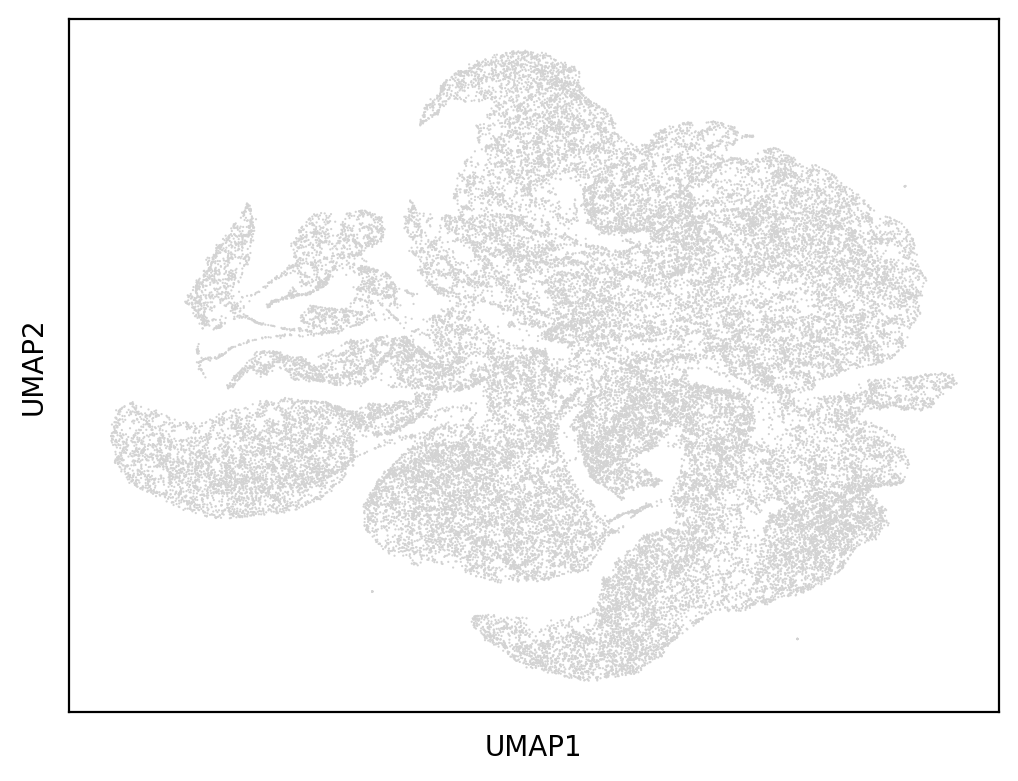

In [14]:
sc.pl.umap(adata)

In [15]:
sc.tl.draw_graph(adata, random_state=123, init_pos="X_umap")

/u/home/s/schhina/.conda/envs/geneformer_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/u/home/s/schhina/.conda/envs/geneformer_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


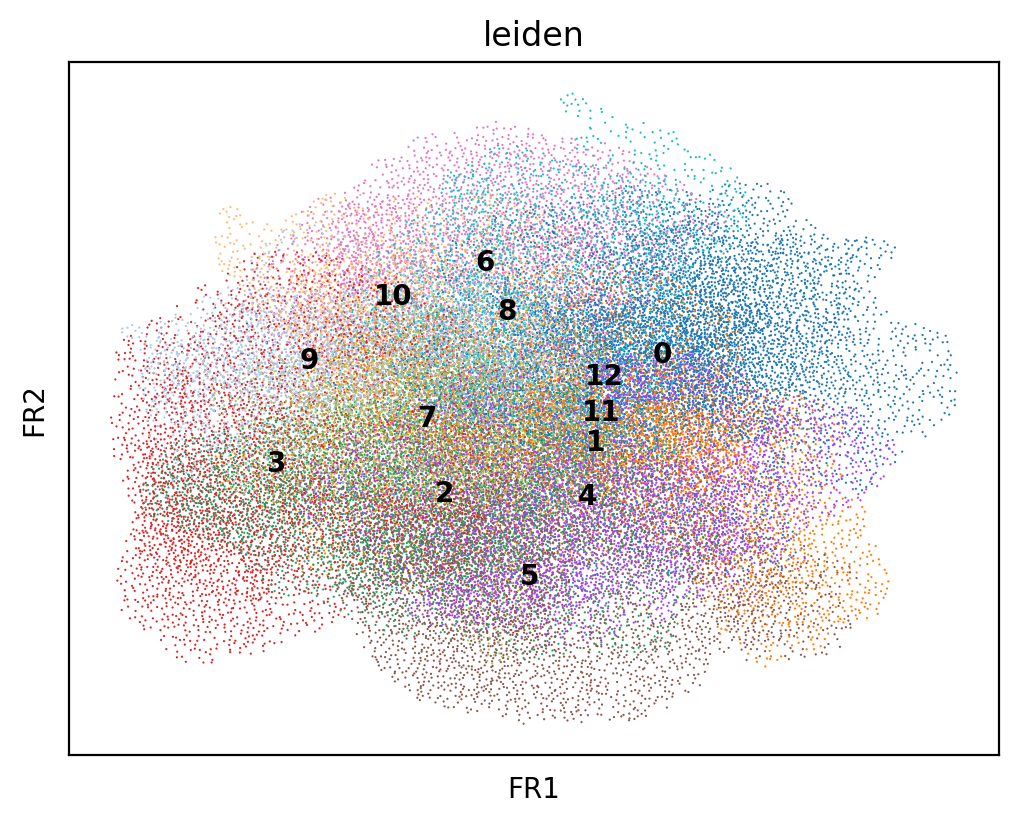

In [14]:
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data')

In [16]:
adata

AnnData object with n_obs × n_vars = 47726 × 2000
    obs: 'stimulation', 'cd_status', 'n_counts_all', 'n_counts', 'leiden'
    var: 'n_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'leiden', 'umap', 'draw_graph'
    obsm: 'X_pca', 'X_diffmap', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

['1000' '9' '9' ... '9' '9' '9']
[0.9609128429230396, 0.41240694789081883, 0.9907088781830695, 0.02103697407564811, 0.9540940189803575, 0.04052734375, 0.030320044918585063, 0.43724219210371246, 0.11005568293481821, 0.5209229565897536, 0.13205351948807445]
[(7916, 322), (2493, 3552), (5758, 54), (99, 4607), (4323, 208), (166, 3930), (108, 3454), (1484, 1910), (336, 2717), (1332, 1225), (227, 1492)]
[(0, (7916, 322)), (1, (2493, 3552)), (2, (5758, 54)), (3, (99, 4607)), (4, (4323, 208)), (5, (166, 3930)), (6, (108, 3454)), (7, (1484, 1910)), (8, (336, 2717)), (9, (1332, 1225)), (10, (227, 1492))]


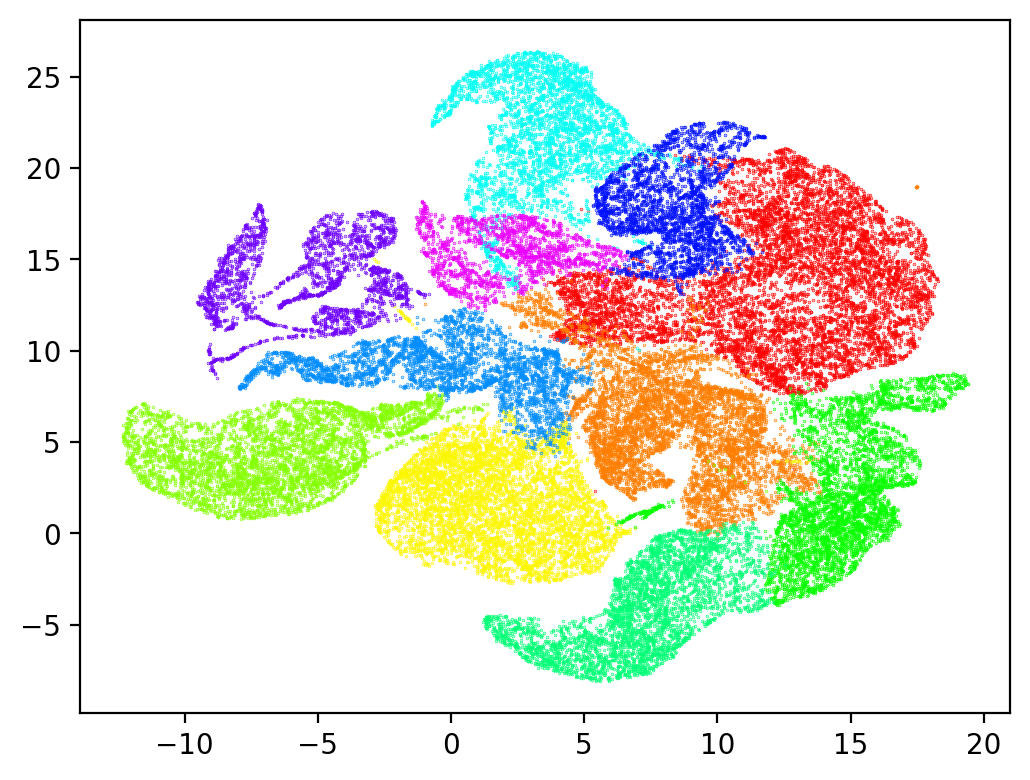

In [86]:
import matplotlib.pyplot as plt

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

x = adata.obsm['X_umap'][:, 0]
y = adata.obsm['X_umap'][:, 1]

clusters = adata.obs['leiden'].to_numpy()
cluster_inds = {}
print(clusters)
c = get_cmap(len(set(clusters)))
for cl in range(len(set(clusters))):
    inds = clusters == f"{cl}"
    cluster_inds[cl] = inds
    plt.scatter(x[inds], y[inds], 0.05, color=c(cl))
    if cl == 10:
        break

stim = adata.obs['stimulation'].to_numpy()
counts = {}

for cl in range(len(cluster_inds)):
    curr_stims = stim[cluster_inds[cl]]
    curr_acts = [x for x in curr_stims == 'act' if x]
    counts[cl] = (len(curr_acts), len(curr_stims) - len(curr_acts))

print([a/(a + r) for a, r in counts.values()])
print([(a, r) for a, r in counts.values()])

sorted_clusters = sorted(counts.items(), key=lambda x: (x[1][0] + x[1][1]))
print(sorted_clusters[::-1])

# res = 0.05, nn_1 = 4, pcs = 30, nn_2 = 10

# 9. Check data
## 9.1. Visualize marker gene expression

In [16]:
plt.rcParams["figure.figsize"] = [4.5, 4.5]

In [17]:
markers = {"Erythroids":["Gata1", "Klf1", "Gypa", "Hba-a2"],
           "Megakaryocytes":["Itga2b", "Pbx1", "Sdpr", "Vwf"],
            "Granulocytes":["Elane", "Cebpe", "Ctsg", "Mpo", "Gfi1"],
            "Monocytes":["Irf8", "Csf1r", "Ctsg", "Mpo"],
            "Mast_cells":["Cma1", "Gzmb", "Kit"],
            "Basophils":["Mcpt8", "Prss34"]
            }

for cell_type, genes in markers.items():
    print(f"marker gene of {cell_type}")
    sc.pl.draw_graph(adata, color=genes, use_raw=False, ncols=2)
    plt.show()



marker gene of Erythroids


KeyError: 'draw_graph'

# 10. [Optional step] Cluster annotation

We will annotate the clusters based on the marker gene expression.


## 9.1. Make annotation (1)

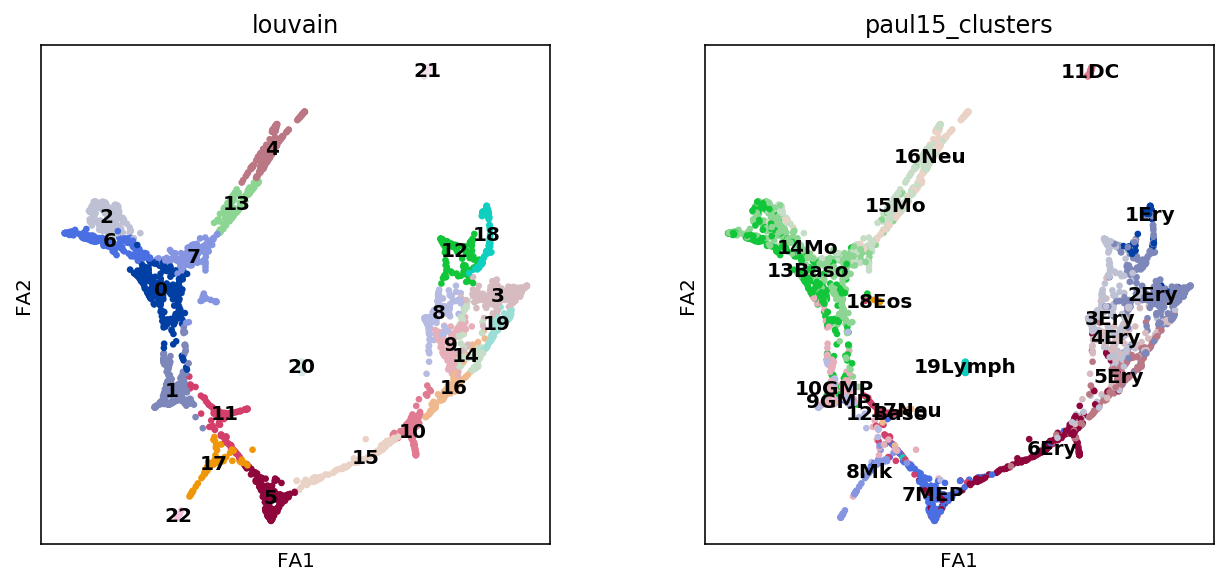

In [20]:
sc.pl.draw_graph(adata, color=['louvain', 'paul15_clusters'],
                 legend_loc='on data')

In [21]:
# Check current cluster name
cluster_list = adata.obs.louvain.unique()
cluster_list

[5, 2, 12, 13, 0, ..., 6, 20, 14, 15, 21]
Length: 23
Categories (23, object): [5, 2, 12, 13, ..., 20, 14, 15, 21]

#### Attention!! Please change the dictionary below depending on the clustering results. The results may change depending on the execution environment.

In [22]:
# Make cluster anottation dictionary
annotation = {"MEP":[5],
              "Erythroids": [15, 10, 16, 9, 8, 14, 19, 3, 12, 18],
              "Megakaryocytes":[17, 22],  
              "GMP":[11, 1],
              "late_GMP" :[0],   
              "Granulocytes":[7, 13, 4],
              "Monocytes":[6, 2],
              "DC":[21],
              "Lymphoid":[20]}

# Change dictionary format
annotation_rev = {}
for i in cluster_list:
    for k in annotation:
        if int(i) in annotation[k]:
            annotation_rev[i] = k
            
# Check dictionary
annotation_rev

{'5': 'MEP',
 '2': 'Monocytes',
 '12': 'Erythroids',
 '13': 'Granulocytes',
 '0': 'late_GMP',
 '10': 'Erythroids',
 '3': 'Erythroids',
 '18': 'Erythroids',
 '11': 'GMP',
 '7': 'Granulocytes',
 '8': 'Erythroids',
 '22': 'Megakaryocytes',
 '16': 'Erythroids',
 '1': 'GMP',
 '17': 'Megakaryocytes',
 '4': 'Granulocytes',
 '19': 'Erythroids',
 '9': 'Erythroids',
 '6': 'Monocytes',
 '20': 'Lymphoid',
 '14': 'Erythroids',
 '15': 'Erythroids',
 '21': 'DC'}

In [23]:
adata.obs["cell_type"] = [annotation_rev[i] for i in adata.obs.louvain]

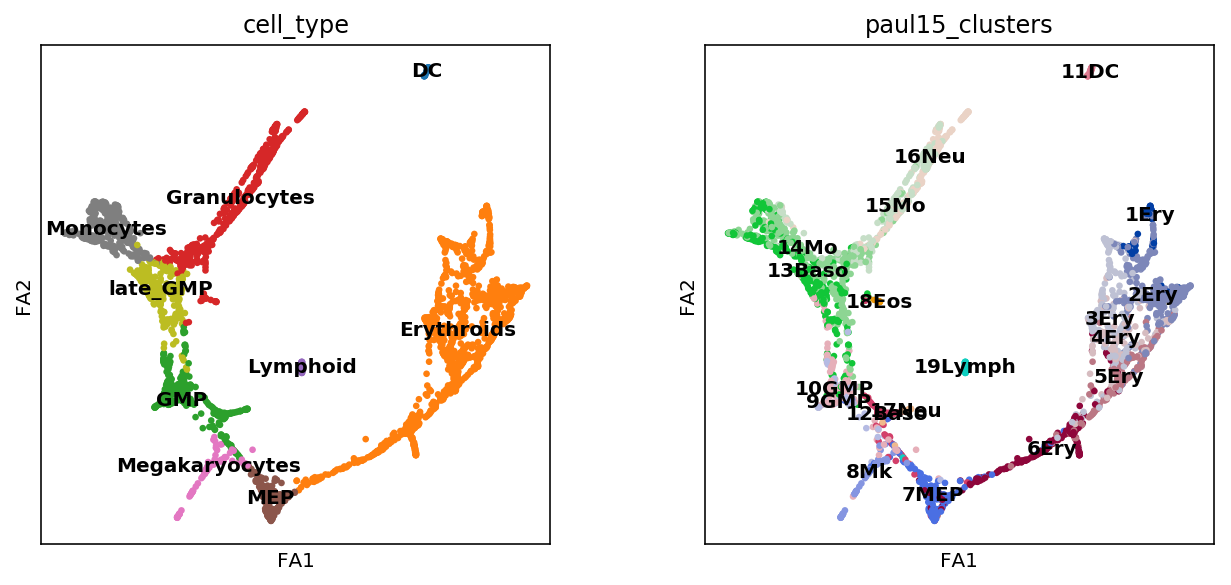

In [24]:
# check results
sc.pl.draw_graph(adata, color=['cell_type', 'paul15_clusters'],
                 legend_loc='on data')

## 10.2. Make annotation (2)
We'll also annotate the indivisual Louvain clusters.

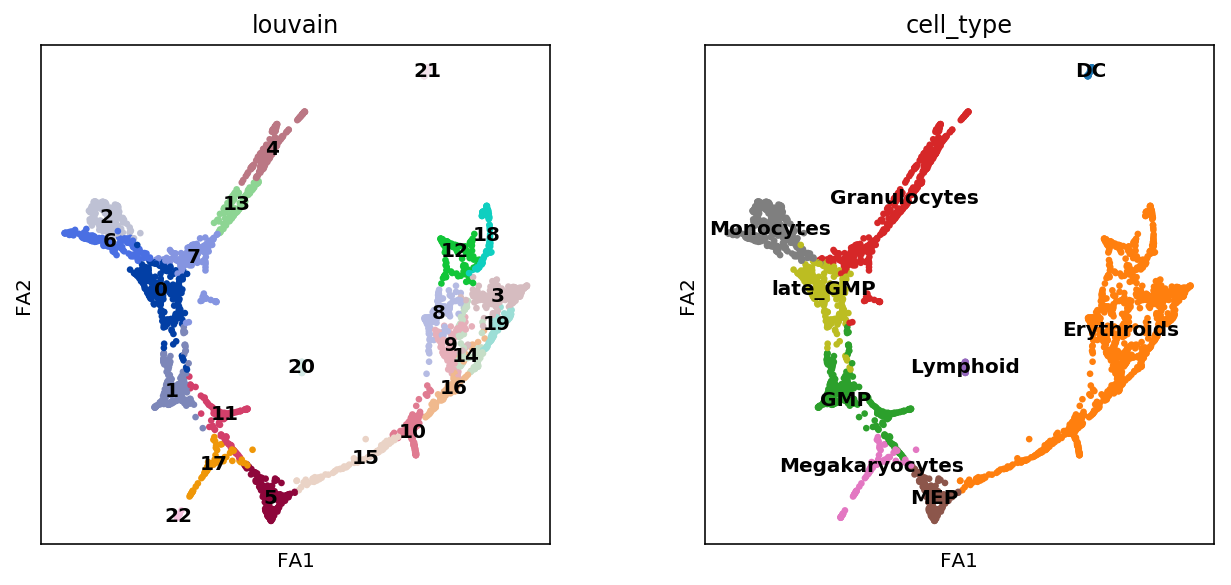

In [25]:
sc.pl.draw_graph(adata, color=['louvain', 'cell_type'],
                 legend_loc='on data')

#### !! Please change the dictionary below depending on the clustering results. The results may change depending on the execution environment.

In [26]:
annotation_2 = {'5': 'MEP_0',
                '15': 'Ery_0',
                '10': 'Ery_1',
                '16': 'Ery_2',
                '14': 'Ery_3',
                '9': 'Ery_4',
                '8': 'Ery_5',
                '19': 'Ery_6',
                '3': 'Ery_7',
                '12': 'Ery_8',
                '18': 'Ery_9',
                '17': 'Mk_0',
                '22': 'Mk_0',
                '11': 'GMP_0',
                '1': 'GMP_1',
                '0': 'GMPl_0',
                '7': 'Gran_0',
                '13': 'Gran_1',
                '4': 'Gran_2',
                '6': 'Mo_0',
                '2': 'Mo_1',
                '21': 'DC_0',
                '20': 'Lym_0'}

In [27]:
adata.obs["louvain_annot"] = [annotation_2[i] for i in adata.obs.louvain]

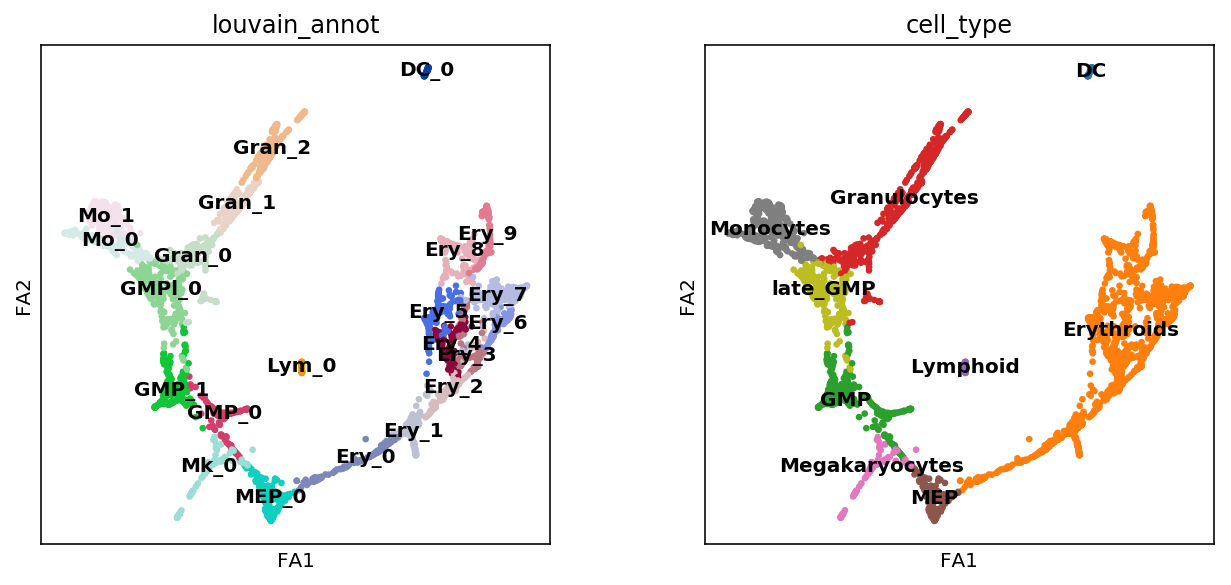

In [28]:
# Check result
sc.pl.draw_graph(adata, color=['louvain_annot', 'cell_type'],
                 legend_loc='on data')

# 11. [Optional step] Subset cells

During the CellOracle analysis, we will focus on the myeloid lineage. Since the othre clusters (i.e. the DC and lymphoid clusters) will not be analyzed, we will choose to remove them now.

It is also important to ensure that the differentiation trajectories are smoothly connected; CellOracle works best with continuous trajectories. If there is discrete cell cluster or non-related cell contamination, please remove them prior to celloracle analysis.

In [29]:
adata.obs.cell_type.unique()

[MEP, Monocytes, Erythroids, Granulocytes, late_GMP, GMP, Megakaryocytes, Lymphoid, DC]
Categories (9, object): [MEP, Monocytes, Erythroids, Granulocytes, ..., GMP, Megakaryocytes, Lymphoid, DC]

In [30]:
cell_of_interest = adata.obs.index[~adata.obs.cell_type.isin(["Lymphoid", "DC"])]
adata = adata[cell_of_interest, :]

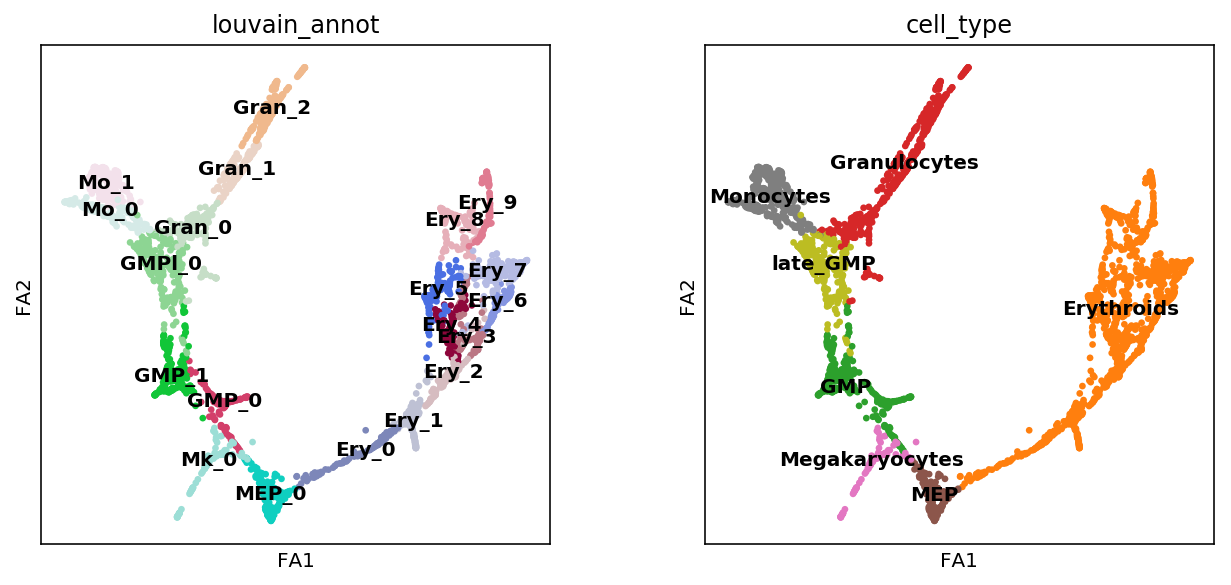

In [31]:
# check result
sc.pl.draw_graph(adata, color=['louvain_annot', 'cell_type'],
                 legend_loc='on data')

# 12. Save processed data

In [29]:
adata.write_h5ad("/u/scratch/s/schhina/cleaned_labeled_active_t_cell_data_celloracle.h5ad")